Idea for tuning:

need to specify which metrics need to be computed, which one needs to be minimized, and how large k is

* build k splits into train and test data
* for each train-test-split:
    * build a parameter grid using cls.tuning_params. (For each class we have to find out what a good grid would be.)
    * for each combination in the grid: 
        * translate api-response into f,m,u and store in the column gender_infered 
        * compute all provided metrics on the resulting test_data DF restricted to training data
        * store relation grid-point:metrics
    * select grid_point which minimizes specified metric and compute all provided metrics on test set
    * store the metrics on test set
* compute average of metrics on all test sets for all metrics

In [1]:
import pandas as pd
from evaluators import *
from helpers import REGISTERED_EVALUATORS
import matplotlib as mpl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


gender_api
gender_api_full
names_api
names_api_full
namsor
gender_guesser
genderize_io


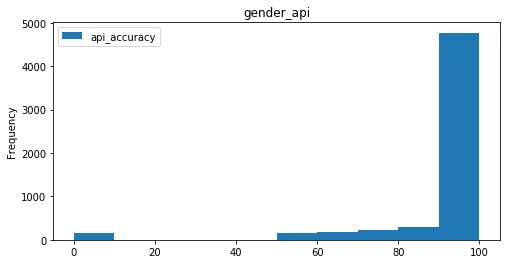

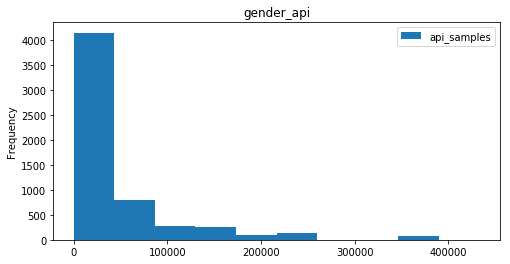

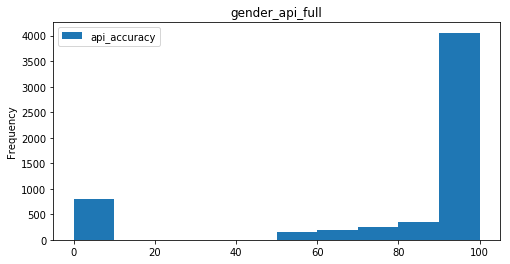

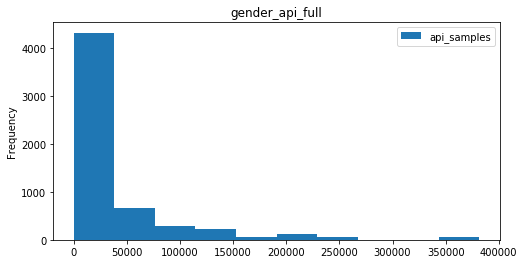

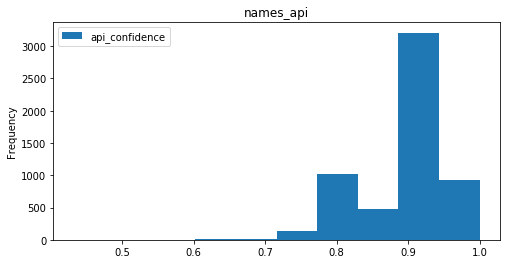

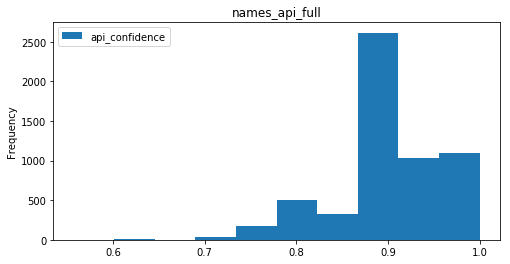

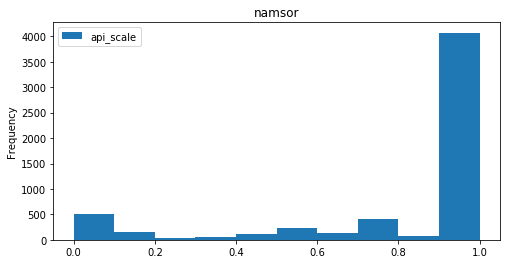

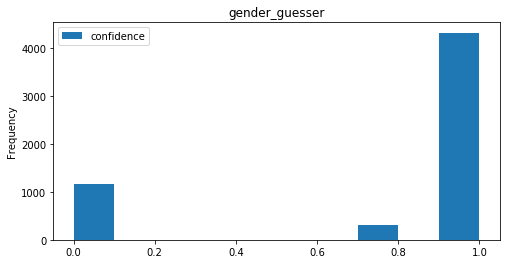

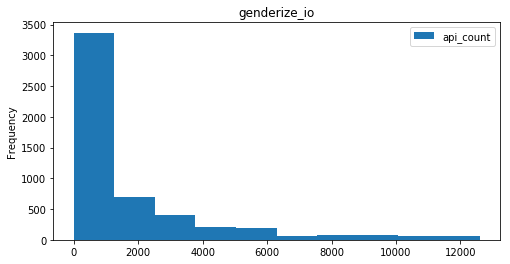

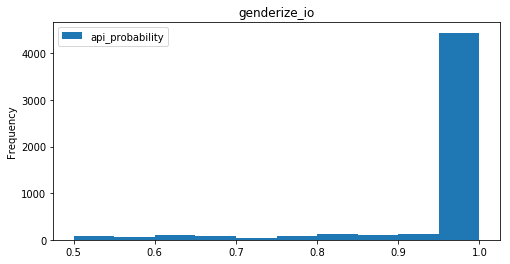

In [6]:
for s in REGISTERED_EVALUATORS:
    print(s.gender_evaluator)
    evaluator = s('all')
    evaluator.load_data(evaluated=True)
    evaluator.preprocess_data_for_parameter_tuning()
    evaluator.remove_rows_with_unknown_gender()
    for param in list(evaluator.tuning_params):
        evaluator.test_data[[param]].plot(kind='hist', stacked=False, title=s.gender_evaluator, figsize=(8,4))
    #break

## `genderize_io`

In [2]:
data_source = 'all'
service_name = GenderizeIoEvaluator
evaluator = service_name(data_source)

evaluator.load_data(evaluated=True)
evaluator.preprocess_data_for_parameter_tuning()
evaluator.remove_rows_with_unknown_gender()

In [3]:
evaluator.test_data.head()

,index,first_name,middle_name,last_name,full_name,gender,origin,api_count,api_gender,api_name,api_probability,gender_infered
0,0,pierre,paul,grivel,pierre paul grivel,m,zbmath,5.0,male,pierre-paul,1.00,m
1,1,raul,,serapioni,raul serapioni,m,zbmath,821.0,male,raul,1.00,m
2,2,adriano,,moura,adriano moura,m,zbmath,166.0,male,adriano,0.99,m
3,3,ralf,,kieser,ralf kieser,m,zbmath,86.0,male,ralf,1.00,m
4,5,guillermo,,leon-de-la-barra,guillermo leon-de-la-barra,m,zbmath,850.0,male,guillermo,1.00,m


In [4]:
evaluator.test_data[list(evaluator.tuning_params)].describe()

,api_count,api_probability
count,5227.000000,5227.000000
mean,1695.015496,0.957744
std,2638.971903,0.105776
min,1.000000,0.500000
25%,46.000000,0.990000
50%,503.000000,1.000000
75%,2201.000000,1.000000
max,12593.000000,1.000000


In [5]:
# show confusion matrix if we do no tuning
evaluator._translate_api_response()
evaluator.compute_confusion_matrix(evaluator.test_data)

,f_pred,m_pred,u_pred
f,1722,88,151
m,220,3197,412
u,0,0,0


In [6]:
# only for testing
evaluator.build_parameter_grid([100, 500, 1000], [0.8, 0.85, 0.9])

[OrderedDict([('api_count', 100), ('api_probability', 0.8)]),
 OrderedDict([('api_count', 100), ('api_probability', 0.85)]),
 OrderedDict([('api_count', 100), ('api_probability', 0.9)]),
 OrderedDict([('api_count', 500), ('api_probability', 0.8)]),
 OrderedDict([('api_count', 500), ('api_probability', 0.85)]),
 OrderedDict([('api_count', 500), ('api_probability', 0.9)]),
 OrderedDict([('api_count', 1000), ('api_probability', 0.8)]),
 OrderedDict([('api_count', 1000), ('api_probability', 0.85)]),
 OrderedDict([('api_count', 1000), ('api_probability', 0.9)])]

In [7]:
# build a sample grid
grid = evaluator.build_parameter_grid([1, 10, 100, 200, 300], 
                                      [0.5, 0.7, 0.8, 0.9, 0.95, 0.97, 0.98, 0.98, 1])

In [8]:
# TODO: turn errors into a nice dataframe for the paper 
index = evaluator.test_data.index
errors = evaluator.compute_error_for_param_grid(grid, evaluator.compute_error_without_unknown, index)
errors 

{(1, 0.5): 0.058924813468528792,
 (1, 0.7): 0.037021969080553295,
 (1, 0.8): 0.031067556296914094,
 (1, 0.9): 0.024731888815933464,
 (1, 0.95): 0.020702070207020702,
 (1, 0.97): 0.019462465245597776,
 (1, 0.98): 0.019458946369245372,
 (1, 1): 0.021270221689634512,
 (10, 0.5): 0.052019315188762072,
 (10, 0.7): 0.030303030303030304,
 (10, 0.8): 0.023661567877629065,
 (10, 0.9): 0.017306245297215951,
 (10, 0.95): 0.012428793371310202,
 (10, 0.97): 0.010712372790573112,
 (10, 0.98): 0.010462555066079295,
 (10, 1): 0.0097968069666182871,
 (100, 0.5): 0.035132819194515851,
 (100, 0.7): 0.01854066985645933,
 (100, 0.8): 0.014625228519195612,
 (100, 0.9): 0.0097545626179987421,
 (100, 0.95): 0.0064370775667846793,
 (100, 0.97): 0.0065984823490597162,
 (100, 0.98): 0.0064232589587559161,
 (100, 1): 0.0051139005113900512,
 (200, 0.5): 0.031496062992125984,
 (200, 0.7): 0.015491100856954515,
 (200, 0.8): 0.013368983957219251,
 (200, 0.9): 0.0089500860585197926,
 (200, 0.95): 0.0059711977520196698

### Try standard errors

In [9]:
evaluator.compute_cv_score(5, grid, evaluator.compute_error_with_unknown)

minimal train error: 0.150723385878 corresponding test error: 0.149266609146
params for lowest train error: {'api_count': 1, 'api_probability': 0.5}
minimal train error: 0.153281519862 corresponding test error: 0.139032815199
params for lowest train error: {'api_count': 1, 'api_probability': 0.5}
minimal train error: 0.148100172712 corresponding test error: 0.1597582038
params for lowest train error: {'api_count': 1, 'api_probability': 0.5}
minimal train error: 0.150690846287 corresponding test error: 0.149395509499
params for lowest train error: {'api_count': 1, 'api_probability': 0.5}
minimal train error: 0.149363263544 corresponding test error: 0.154710458081
params for lowest train error: {'api_count': 1, 'api_probability': 0.5}


0.15043271914489384

In [10]:
evaluator.compute_cv_score(5, grid, evaluator.compute_error_without_unknown)

minimal train error: 0.00334448160535 corresponding test error: 0.00257731958763
params for lowest train error: {'api_count': 300, 'api_probability': 1}
minimal train error: 0.00333333333333 corresponding test error: 0.00261096605744
params for lowest train error: {'api_count': 300, 'api_probability': 1}
minimal train error: 0.00394736842105 corresponding test error: 0.0
params for lowest train error: {'api_count': 300, 'api_probability': 1}
minimal train error: 0.00331125827815 corresponding test error: 0.00268096514745
params for lowest train error: {'api_count': 300, 'api_probability': 1}
minimal train error: 0.00199071001991 corresponding test error: 0.00797872340426
params for lowest train error: {'api_count': 300, 'api_probability': 1}


0.0031695948393557043

In [11]:
evaluator.compute_cv_score(5, grid, evaluator.compute_error_unknown)

minimal train error: 0.0995465342259 corresponding test error: 0.0880069025022
params for lowest train error: {'api_count': 1, 'api_probability': 0.5}
minimal train error: 0.0984455958549 corresponding test error: 0.0924006908463
params for lowest train error: {'api_count': 1, 'api_probability': 0.5}
minimal train error: 0.0949913644214 corresponding test error: 0.10621761658
params for lowest train error: {'api_count': 1, 'api_probability': 0.5}
minimal train error: 0.0971502590674 corresponding test error: 0.0975820379965
params for lowest train error: {'api_count': 1, 'api_probability': 0.5}
minimal train error: 0.096050075545 corresponding test error: 0.101987899741
params for lowest train error: {'api_count': 1, 'api_probability': 0.5}


0.097239029533201821

### Try out a weighted version of `compute_error_with_unknown`

In [12]:
evaluator.compute_cv_score(5, grid, evaluator.compute_weighted_error)

minimal train error: 0.0850524791893 corresponding test error: 0.0887104575796
params for lowest train error: {'api_count': 1, 'api_probability': 0.7}
minimal train error: 0.0872564443907 corresponding test error: 0.0799656061909
params for lowest train error: {'api_count': 1, 'api_probability': 0.7}
minimal train error: 0.0845121334072 corresponding test error: 0.0909090909091
params for lowest train error: {'api_count': 1, 'api_probability': 0.7}
minimal train error: 0.0863446544524 corresponding test error: 0.0835345243844
params for lowest train error: {'api_count': 1, 'api_probability': 0.7}
minimal train error: 0.0857542708233 corresponding test error: 0.0858966918166
params for lowest train error: {'api_count': 1, 'api_probability': 0.7}


0.08580327417609987

In [13]:
# show confusion matrix if we tune parameters according to error function 'compute_weighted_error'
evaluator._translate_api_response(api_count=1, api_probability=0.7)
evaluator.compute_confusion_matrix(evaluator.test_data)

,f_pred,m_pred,u_pred
f,1671,52,238
m,130,3063,636
u,0,0,0


### try setting a constraint

In [14]:
# we tune parameters such that 'error_func' is minimised on the training sets 
# but under the constraint that 'constraint_func' is less than 'constraint_val' on test set
evaluator.compute_cv_score(n_splits=5, param_grid=grid, error_func=evaluator.compute_error_without_unknown,
                          constraint_func=evaluator.compute_error_with_unknown, constraint_val=0.1)

No parameter values satisfied given constraint
No parameter values satisfied given constraint


In [15]:
evaluator.compute_cv_score(n_splits=5, param_grid=grid, error_func=evaluator.compute_error_without_unknown,
                          constraint_func=evaluator.compute_error_with_unknown, constraint_val=0.5)

minimal train error: 0.00675675675676 corresponding test error: 0.00508474576271
params for lowest train error: {'api_count': 100, 'api_probability': 0.98}
minimal train error: 0.0061919504644 corresponding test error: 0.00511945392491
params for lowest train error: {'api_count': 200, 'api_probability': 0.95}
minimal train error: 0.00678913738019 corresponding test error: 0.00497512437811
params for lowest train error: {'api_count': 100, 'api_probability': 0.95}
minimal train error: 0.00590468156896 corresponding test error: 0.00851788756388
params for lowest train error: {'api_count': 100, 'api_probability': 0.98}
minimal train error: 0.00549915397631 corresponding test error: 0.010101010101
params for lowest train error: {'api_count': 100, 'api_probability': 0.98}


0.006759644346126051

In [19]:
evaluator.compute_cv_score(n_splits=5, param_grid=grid, error_func=evaluator.compute_error_without_unknown,
                          constraint_func=evaluator.compute_error_unknown, constraint_val=0.25)

minimal train error: 0.0199494239955 corresponding test error: 0.0237288135593
params for lowest train error: {'api_count': 1, 'api_probability': 0.95}
minimal train error: 0.0195278344506 corresponding test error: 0.019209039548
params for lowest train error: {'api_count': 1, 'api_probability': 0.97}
minimal train error: 0.0212587412587 corresponding test error: 0.0184119677791
params for lowest train error: {'api_count': 1, 'api_probability': 0.95}
minimal train error: 0.019437191761 corresponding test error: 0.0195627157652
params for lowest train error: {'api_count': 1, 'api_probability': 0.97}
minimal train error: 0.0205056179775 corresponding test error: 0.0214932126697
params for lowest train error: {'api_count': 1, 'api_probability': 0.95}


0.02048114986426634

## `gender_api`

In [4]:
data_source = 'all'
service_name = GenderAPIEvaluator
evaluator = service_name(data_source)

evaluator.load_data(evaluated=True)
evaluator.preprocess_data_for_parameter_tuning()
evaluator.remove_rows_with_unknown_gender()

In [5]:
evaluator.tuning_params

('api_accuracy', 'api_samples')

In [6]:
evaluator.test_data[list(evaluator.tuning_params)].describe()

,api_accuracy,api_samples
count,5790.000000,5790.000000
mean,91.385320,40243.978066
std,18.721861,66650.027682
min,0.000000,0.000000
25%,95.000000,987.000000
50%,98.000000,11153.000000
75%,99.000000,51412.000000
max,100.000000,433182.000000


In [7]:
evaluator.test_data.dtypes

index              int64
first_name        object
middle_name       object
last_name         object
full_name         object
gender            object
origin            object
api_accuracy       int64
api_duration      object
gender_infered    object
api_name          object
api_samples        int64
api_gender        object
dtype: object

In [8]:
# show confusion matrix if we do no tuning
evaluator._translate_api_response()
evaluator.compute_confusion_matrix(evaluator.test_data)

,f_pred,m_pred,u_pred
f,1728,187,46
m,141,3560,128
u,0,0,0


In [9]:
grid = evaluator.build_parameter_grid([50, 60, 70, 80, 90, 95], [10000, 20000, 30000, 40000, 50000, 60000])

In [10]:
evaluator.compute_cv_score(5, grid, evaluator.compute_error_without_unknown)

minimal train error: 0.00460405156538 corresponding test error: 0.00684931506849
params for lowest train error: {'api_accuracy': 95, 'api_samples': 50000}
minimal train error: 0.00522951772225 corresponding test error: 0.00660792951542
params for lowest train error: {'api_accuracy': 95, 'api_samples': 20000}
minimal train error: 0.00542005420054 corresponding test error: 0.00369003690037
params for lowest train error: {'api_accuracy': 95, 'api_samples': 50000}
minimal train error: 0.00441014332966 corresponding test error: 0.010152284264
params for lowest train error: {'api_accuracy': 95, 'api_samples': 60000}
minimal train error: 0.00546946216955 corresponding test error: 0.00355871886121
params for lowest train error: {'api_accuracy': 95, 'api_samples': 50000}


0.0061716569218900012

In [11]:
evaluator.compute_cv_score(5, grid, evaluator.compute_error_with_unknown)

minimal train error: 0.501187648456 corresponding test error: 0.485763589301
params for lowest train error: {'api_accuracy': 50, 'api_samples': 10000}
minimal train error: 0.502374784111 corresponding test error: 0.481001727116
params for lowest train error: {'api_accuracy': 50, 'api_samples': 10000}
minimal train error: 0.49201208981 corresponding test error: 0.522452504318
params for lowest train error: {'api_accuracy': 50, 'api_samples': 10000}
minimal train error: 0.495250431779 corresponding test error: 0.509499136442
params for lowest train error: {'api_accuracy': 50, 'api_samples': 10000}
minimal train error: 0.4996762357 corresponding test error: 0.491789109767
params for lowest train error: {'api_accuracy': 50, 'api_samples': 10000}


0.49810121338868141